In [1]:
import scanpy as sc

In [2]:
ad = sc.read_h5ad("/Volumes/processing2/RRmap/data/EAE_MANA_annotated_gmm_clust_with_scores_anno_comp.h5ad")

IORegistryError: No read method registered for IOSpec(encoding_type='null', encoding_version='0.1.0') from <class 'h5py._hl.dataset.Dataset'>. You may need to update your installation of anndata.

In [ ]:
# Marker inspection + scoring for proliferation and apoptosis
import scanpy as sc

# Mouse gene symbols (adjust case if your panel uses uppercase)
prolif = [
    'Mki67','Top2a','Mcm2','Mcm3','Mcm4','Mcm5','Mcm6','Mcm7','Pcna','Tyms',
    'Cdk1','Ccna2','Ccnb1','Ccnb2','Cenpf','Aurka','Aurkb','Birc5','Ube2c'
]
apopt = [
    'Casp3','Casp7','Casp8','Casp9','Bax','Bak1','Bcl2l11','Bbc3','Pmaip1',
    'Fas','Fasl','Tnfrsf10b','Tnfsf10','Apaf1','Bid'
]

present_prolif = [g for g in prolif if g in ad.var_names]
present_apopt = [g for g in apopt if g in ad.var_names]

print('Proliferation in panel:', present_prolif)
print('Apoptosis in panel:', present_apopt)

# Score genes (safe to run even if list is short)
if len(present_prolif) > 0:
    sc.tl.score_genes(ad, present_prolif, score_name='prolif_score')
else:
    print('No proliferation markers found in var_names')

if len(present_apopt) > 0:
    sc.tl.score_genes(ad, present_apopt, score_name='apopt_score')
else:
    print('No apoptosis markers found in var_names')

# Basic summaries
cols = [c for c in ['prolif_score','apopt_score'] if c in ad.obs.columns]
ad.obs[cols].describe()


In [ ]:
# Quick plots by annotated cell type (edit the column name if needed)
cell_type_col = 'anno_L2'
if cell_type_col in ad.obs.columns:
    sc.pl.violin(ad, keys=[c for c in ['prolif_score','apopt_score'] if c in ad.obs.columns],
                 groupby=cell_type_col, rotation=90, stripplot=False, jitter=False)
else:
    print(f'Missing cell type column: {cell_type_col}')


In [ ]:
# Inspect obs columns to locate spatial coords and IDs
list(ad.obs.columns)[:50]


In [40]:
# Build single_cell_df for OSDR
import numpy as np
import pandas as pd
from tdm.preprocess.single_cell_df import check_single_cell_df
from tdm.utils import microns

cell_type_col = 'anno_L2'

# Find x/y columns (edit if needed)
candidates = [
    ('x','y'),
    ('X','Y'),
    ('x_centroid','y_centroid'),
    ('X_centroid','Y_centroid'),
    ('centroid_x','centroid_y'),
]
x_col = y_col = None
for cx, cy in candidates:
    if cx in ad.obs.columns and cy in ad.obs.columns:
        x_col, y_col = cx, cy
        break
if x_col is None:
    raise ValueError('Could not find spatial columns. Set x_col/y_col manually.')

# Optional IDs (set to constants if missing)
img_id_col = 'fov_id' if 'fov_id' in ad.obs.columns else ('sample_id' if 'sample_id' in ad.obs.columns else None)
subject_id_col = 'subject_id' if 'subject_id' in ad.obs.columns else ('sample_id' if 'sample_id' in ad.obs.columns else None)

# Define dividing cells from prolif_score (adjust percentile as needed)
prolif_q = ad.obs['prolif_score'].quantile(0.98)
division = ad.obs['prolif_score'] >= prolif_q

# Assume coordinates are in microns; set to False if already in meters
coords_in_microns = True
x_vals = ad.obs[x_col].astype(float)
y_vals = ad.obs[y_col].astype(float)
if coords_in_microns:
    x_vals = microns(x_vals)
    y_vals = microns(y_vals)

single_cell_df = pd.DataFrame({
    'x': x_vals,
    'y': y_vals,
    'cell_type': ad.obs[cell_type_col].astype(str),
    'division': division.astype(bool),
    'img_id': ad.obs[img_id_col].astype(str) if img_id_col else '1',
    'subject_id': ad.obs[subject_id_col].astype(str) if subject_id_col else '1',
})

# Validate
check_single_cell_df(single_cell_df)


Validating single cell dataframe...

[SUCCESS] Found x column


                The spatial positions within the tissue should range from (0,0) to (x max, y max)
                
[SUCCESS] Found y column
[SUCCESS] Found cell_type column. Number of cell types: 21
	Cell types: ['Schwann cell', 'Artifact', 'Interneuron', 'Macrophage', 'Oligodendrocyte', 'Meningeal fibroblast', 'Microglia', 'Endothelial', 'Perineurial', 'T cell', 'Astrocyte', 'Monocyte-derived', 'Dendritic cell', 'OPC', 'Neuron', 'Pericyte', 'BAM', 'VSMC', 'B cell', 'Arachnoid barrier', 'Other']
[SUCCESS] Found division column. Fraction of dividing cells: 0.020
[SUCCESS] Found img_id column. Number of images found: 107
[SUCCESS] Found subject_id column. Number of subjects found: 107

[SUCCESS] Validation complete!


True

In [41]:
# Pick cell types to model (start with 2 for phase-portrait plots)
type_counts = single_cell_df['cell_type'].value_counts()
type_counts.head(20)


cell_type
Oligodendrocyte         174835
Interneuron             130506
Microglia               103816
Astrocyte               102125
Endothelial              60810
Meningeal fibroblast     42899
Macrophage               42745
Neuron                   39572
T cell                   31211
Schwann cell             24869
OPC                      21822
Arachnoid barrier        15851
BAM                      14443
Dendritic cell           14415
Artifact                  9699
B cell                    9680
Pericyte                  9643
VSMC                      8440
Perineurial               7482
Monocyte-derived          6380
Name: count, dtype: int64

In [55]:
cell_types_to_model

['Oligodendrocyte', 'Interneuron', 'Microglia', 'Astrocyte']

In [58]:
# Select cell types to model
# Option A: manually set two types for a single phase portrait
cell_types_to_model = [
    #'OPC','T cell'# e.g. 'Microglia', 'T cell'
]

# Option B: auto-select top N types by abundance
auto_pick = True
top_n = 20
if auto_pick:
    cell_types_to_model = type_counts.head(top_n).index.tolist()

# Allowed neighbor types: start with the same set or extend
allowed_neighbor_types = cell_types_to_model


In [59]:
cell_types_to_model

['Oligodendrocyte',
 'Interneuron',
 'Microglia',
 'Astrocyte',
 'Endothelial',
 'Meningeal fibroblast',
 'Macrophage',
 'Neuron',
 'T cell',
 'Schwann cell',
 'OPC',
 'Arachnoid barrier',
 'BAM',
 'Dendritic cell',
 'Artifact',
 'B cell',
 'Pericyte',
 'VSMC',
 'Perineurial',
 'Monocyte-derived']

In [60]:
# Run OSDR analysis
from tdm.analysis import Analysis

ana = Analysis(
    single_cell_df=single_cell_df,
    cell_types_to_model=cell_types_to_model,
    allowed_neighbor_types=allowed_neighbor_types,
    polynomial_dataset_kwargs={'degree': 1},
    neighborhood_mode='extrapolate',
    enforce_max_density=False,
    model_kwargs={'regularization_alpha': 1e-3},
)


1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]


KeyboardInterrupt: 

In [ ]:
ana

Plotting Oligodendrocyte vs Interneuron
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


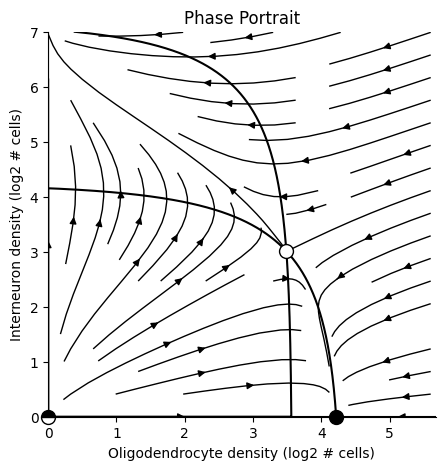

Plotting Oligodendrocyte vs Microglia
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


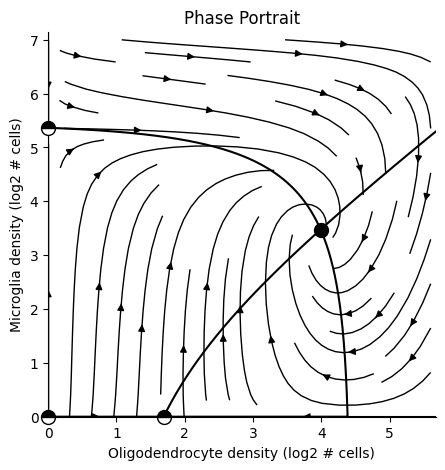

Plotting Oligodendrocyte vs Astrocyte
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


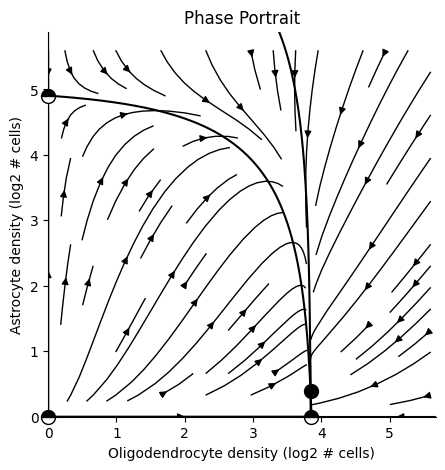

Plotting Oligodendrocyte vs Endothelial
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


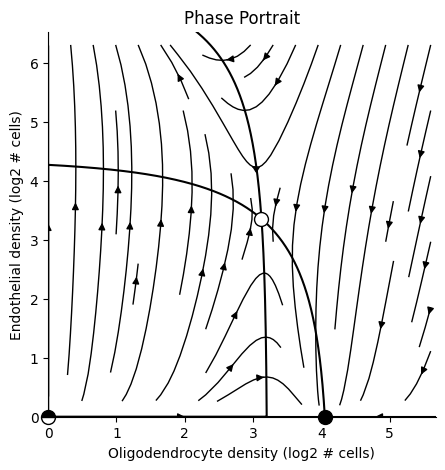

Plotting Oligodendrocyte vs Meningeal fibroblast
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


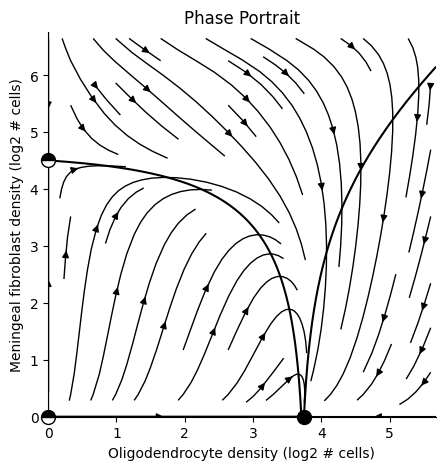

Plotting Oligodendrocyte vs Macrophage
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


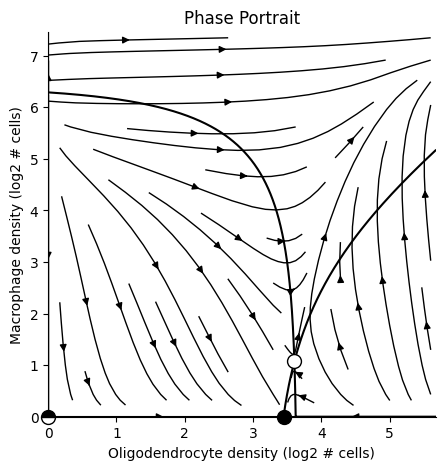

Plotting Oligodendrocyte vs Neuron
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


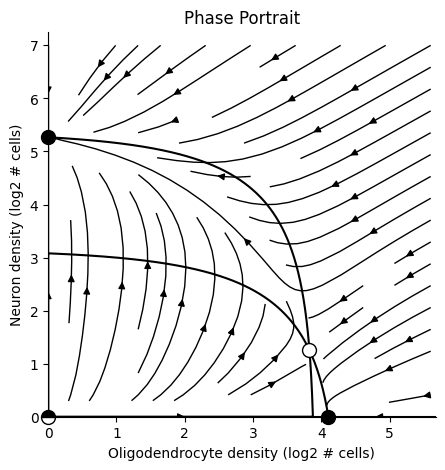

Plotting Oligodendrocyte vs T cell
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


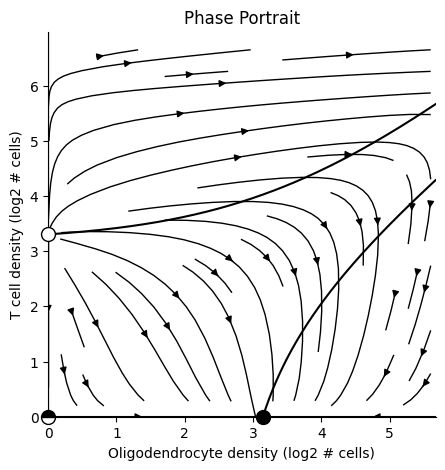

Plotting Oligodendrocyte vs Schwann cell
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


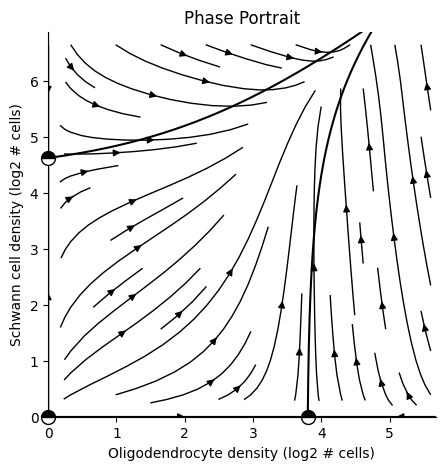

Plotting Oligodendrocyte vs OPC
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


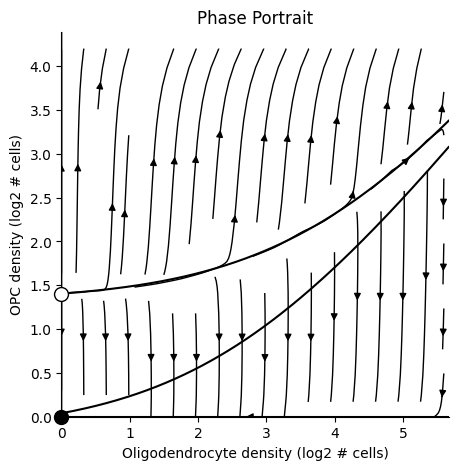

Plotting Oligodendrocyte vs Arachnoid barrier
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


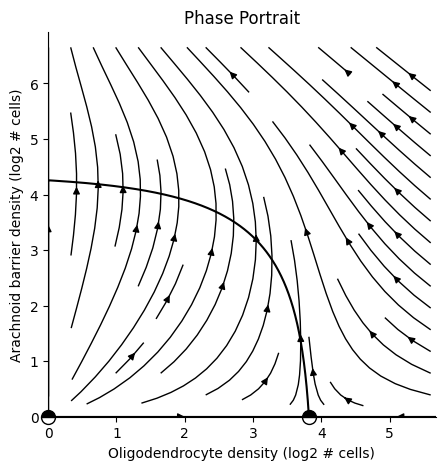

Plotting Oligodendrocyte vs BAM
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


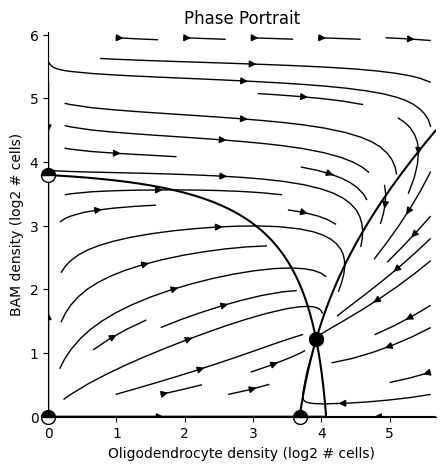

Plotting Oligodendrocyte vs Dendritic cell
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


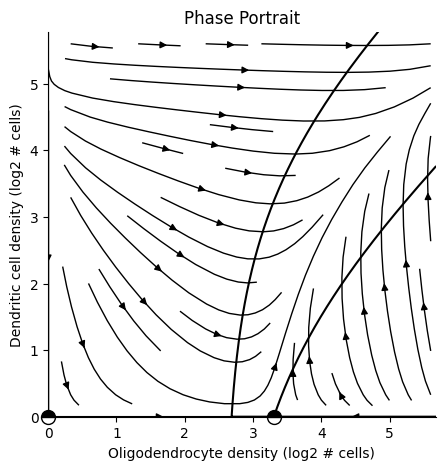

Plotting Oligodendrocyte vs Artifact
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


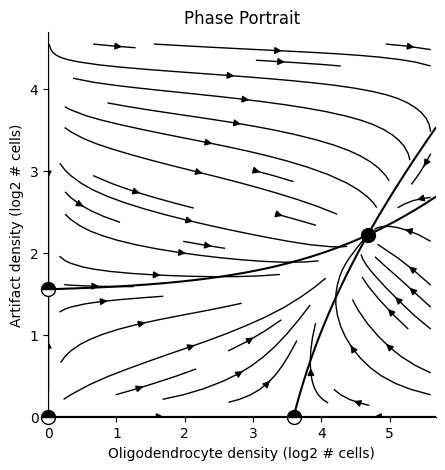

Plotting Oligodendrocyte vs B cell
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


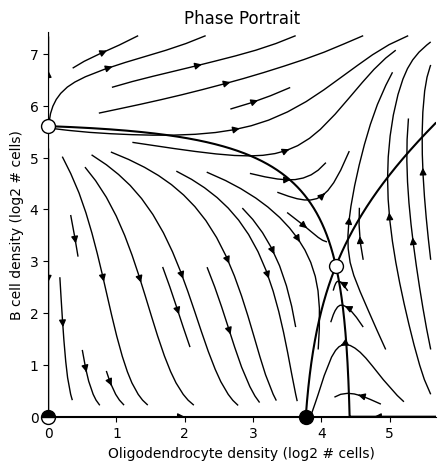

Plotting Oligodendrocyte vs Pericyte
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


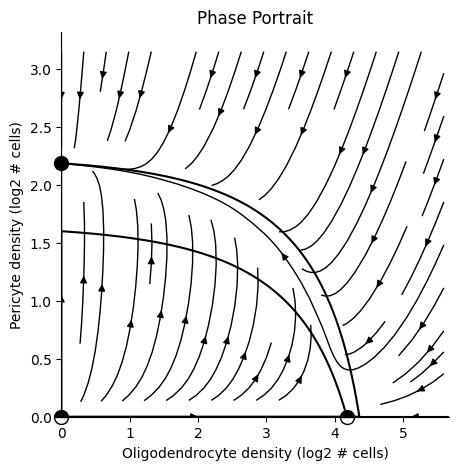

Plotting Oligodendrocyte vs VSMC
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


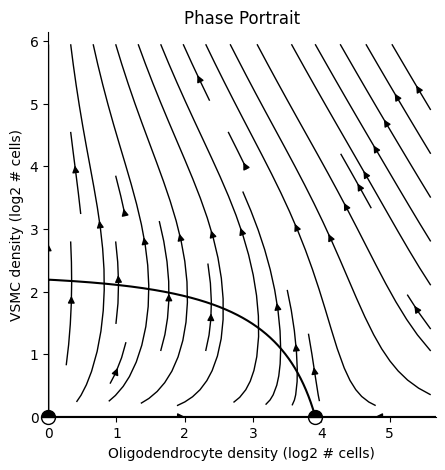

Plotting Oligodendrocyte vs Perineurial
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


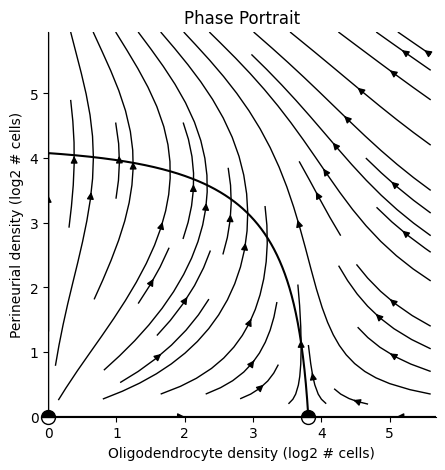

Plotting Oligodendrocyte vs Monocyte-derived
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


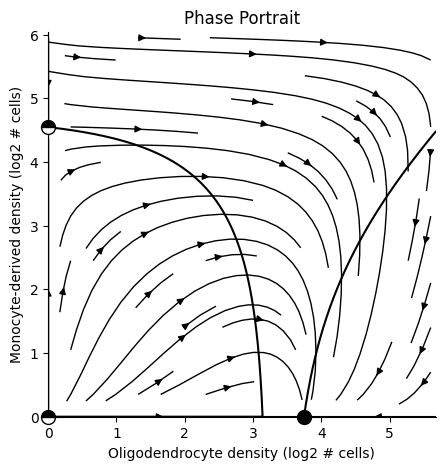

Plotting Interneuron vs Microglia
1/5 Constructing tissues [V]
2/5 Counting cell-neighbors 

In [ ]:
# Plot phase portraits for all pairs (if >2 types)
from itertools import combinations
from tdm.plot.two_cells.phase_portrait import plot_phase_portrait
import matplotlib.pyplot as plt

if len(cell_types_to_model) == 2:
    plot_phase_portrait(ana)
    plt.show()
else:
    for a, b in combinations(cell_types_to_model, 2):
        print(f'Plotting {a} vs {b}')
        ana_pair = Analysis(
            single_cell_df=single_cell_df,
            cell_types_to_model=[a, b],
            allowed_neighbor_types=allowed_neighbor_types,
            polynomial_dataset_kwargs={'degree': 1},
            neighborhood_mode='extrapolate',
            enforce_max_density=False,
            model_kwargs={'regularization_alpha': 1e-3},
        )
        plot_phase_portrait(ana_pair)
        plt.show()
